# Training Agents using Upside-Down Reinforcement Learning

See original papers:
1. [Reinforcement Learning Upside Down: Don't Predict Rewards -- Just Map Them to Actions](https://arxiv.org/abs/1912.02875)
2. [Training Agents using Upside-Down Reinforcement Learning](https://arxiv.org/abs/1912.02877)

The content below is based on the [second paper](https://arxiv.org/abs/1912.02877), followed by my interpretation (implementation) of this content 

In [1]:
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Categorical
from collections import namedtuple

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings("ignore")

# Traing on GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# Helper function to create episodes as namedtuple
make_episode = namedtuple('Episode', 
                          field_names=['states', 
                                       'actions', 
                                       'rewards', 
                                       'init_command', 
                                       'total_return', 
                                       'length', 
                                       ])

# Introduction

While there is a rich history of techniques that incorporate supervised learning (SL) into reinforcement learning (RL) algorithms, it is believed that fully solving RL problems using SL is not possible, because feedback from the environment provides error signals in SL but evaluation signals in RL. Put simply, an agent gets feedback about how useful its actions are, but not about which actions are the best to take in any situation. On the possibility of turning an RL problem into an SL problem, Barto and Dietterich surmised: _"In general, there is no way to do this."_

In a companion technical report, Schmidhuber proposes to bridge this gap between SL and RL through UpsideDown Reinforcement Learning (⅂ꓤ), where environmental feedback – such as the reward – is an input rather than the learning target as in traditional RL algorithms based on reward prediction. Here we develop a practical RL algorithm for episodic tasks and show that it is indeed possible to train agents in general model-free settings without using value-based algorithms such as Q-learning, or policy-based ones such as policy gradients and evolutionary algorithms. Instead, RL uses pure SL to train an agent on all past experiences, and sidesteps the issues arising from the combination of function approximation, bootstrapping and off-policy training. We first describe its basic principles, then experimentally demonstrate its practical feasibility on three RL problems with both sparse and dense reward structure.

<img src="images/rl_vs_udrl.png" />

<img src="images/toy_env.png" />

# Knowledge Representation

Traditional model-free RL algorithms can be broadly classified as being value-based or policy-based. The core principle of value-based algorithms is reward prediction: agents are trained to predict the expected discounted future return for taking any action in any state, commonly using TD learning. Policy-based algorithms are instead based on directly searching for policies that maximize returns. The basic principle of ⅂ꓤ are different from both of these categories: given a particular definition of _commands_, it defines a _behavior function_ that encapsulates knowledge about the behaviors observed so far compatible with known commands. The nature of the behavior function is explained using two examples below.

### Example 1

Consider a simple dart-throwing environment where each episode lasts a single step. An agent learning to throw darts receives a return inversely proportional to the hit distance from the center of the board. In each episode, the agent observes the initial state of the dart, and takes an action that determines the force and direction of the throw. Using value-based RL for this task would amount to training the agent to predict the expected return for various actions and initial states. This knowledge would then be used for action selection e.g. taking the action with the highest expected return.

In ⅂ꓤ, the agent’s knowledge is represented not in terms of expected returns for various states and actions, but in terms of actions that are compatible with various states and desired returns i.e. the inputs and targets of the agent’s learning procedure are switched. The dart throwing agent would be trained to directly produce the actions for hitting desired locations on the board, using a behavior function B<sup>2</sup> learned using its past experience. Figure 1 schematically illustrates this difference between B and the Q-value function commonly used in value based RL. Since this environment consists of episodes with a single time step, both Q and B can be learned using SL. 

The next example illustrates a slightly more typical RL setting with longer time horizons.

### Example 2

Consider the simple deterministic Markovian environment in Figure 2 in which all trajectories start in s<sub>0</sub> or s<sub>1</sub> and end in s<sub>2</sub> or s<sub>3</sub>. Additionally consider commands of the type: achieve a given desired return in a given desired horizon from the current state. A behavior function based on the set of all unique behaviors possible in this environment can then be expressed in a tabular form in Table 1. It maps states and commands to the action to be taken in that state compatible with executing the command. In other words, it answers the question: _"if an agent is in a given state and desires a given return over a given horizon, which action should it take next?"_ By design, this function can now be used to execute any valid command in the environment without further knowledge.

Two properties of the behavior function are notable. First, the output of B can be stochastic even in a deterministic environment since there may be multiple valid behaviors compatible with the same command and state. For example, this would be the case if the transition s<sub>0</sub> → s<sub>2</sub> had a reward of 2. So in general, B produces a probability distribution over actions. Second, B fundamentally depends on the set of trajectories used to construct it. Using a loss function _L_, we define the optimal behavior function B<sup>∗</sup><sub>Т</sub> for a set of trajectories Т as

<p><img src="images/optimal_B.png" width="320" /></p>

Here len(τ) is the length of any trajectory τ. For a suitably parameterized B, we use the cross-entropy between the observed and predicted distributions of actions as the loss function. Equivalently, we search for parameters that maximize the likelihood that the behavior function generates the available data, using the traditional tools of supervised learning. Similarly, we can define a behavior function over a policy. Instead of a set of trajectories, B<sup>∗</sup><sub>π</sub> minimizes the same loss over the distribution of trajectories generated when acting according to π.

# ⅂ꓤ Algorithm for Maximizing Episodic Returns

In principle, a behavior function can be learned for any policy that generates all possible trajectories in an environment given suficient time (e.g. a random policy) and then used to select actions that lead to any desired return in a desired horizon achievable in the environment. But such a learning procedure is not practical since it relies on undirected exploration using a fixed policy. Moreover, in environments with scalar rewards, the goal is to learn to achieve high returns and not to achieve any possible return over any horizon. Therefore, the concrete algorithm used in this paper trains a behavior function on the set of trajectories (or the agent’s experience) so far and incorporates minimal additions that enable the continual collection of trajectories with higher returns.

<img src="images/udrl_algo1.png" />

High-level pseudo-code for the proposed algorithm is described in Algorithm 1. It starts by initializing an empty replay buffer to collect the agent’s experiences during training, and filling it with a few episodes of random interactions. The behavior function of the agent is continually improved by supervised training on previous experiences recorded in the replay buffer. After each training phase, the behavior function is used to act in the environment to obtain new experiences that are added to the replay buffer. This procedure continues until a stopping criterion is met, such as reaching the allowed maximum number of interactions with the environment. The remainder of this section describes each step of the algorithm and introduces the hyperparameters.

In [4]:
def initialize_replay_buffer(replay_size, n_episodes, last_few):
    '''
    Initialize replay buffer with warm-up episodes using random actions.
    See section 2.3.1
    
    Params:
        replay_size (int)
        n_episodes (int)
        last_few (int)
    
    Returns:
        ReplayBuffer instance
        
    '''
    
    # This policy will generate random actions. Won't need state nor command
    random_policy = lambda state, command: np.random.randint(env.action_space.n)
    
    buffer = ReplayBuffer(replay_size)
    
    for i in range(n_episodes):
        command = sample_command(buffer, last_few)
        episode = generate_episode(env, random_policy, command) # See Algorithm 2
        buffer.add(episode)
    
    buffer.sort()
    return buffer

def initialize_behavior_function(state_size, 
                                 action_size, 
                                 hidden_size, 
                                 learning_rate, 
                                 command_scale):
    '''
    Initialize the behaviour function. See section 2.3.2
    
    Params:
        state_size (int)
        action_size (int)
        hidden_size (int) -- NOTE: not used at the moment
        learning_rate (float)
        command_scale (List of float)
    
    Returns:
        Behavior instance
    
    '''
    
    behavior = Behavior(state_size, 
                        action_size, 
                        hidden_size, 
                        command_scale)
    
    behavior.init_optimizer(lr=learning_rate)
    
    return behavior

def generate_episodes(env, behavior, buffer, n_episodes, last_few):
    '''
    1. Sample exploratory commands based on replay buffer
    2. Generate episodes using Algorithm 2 and add to replay buffer
    
    Params:
        env (OpenAI Gym Environment)
        behavior (Behavior)
        buffer (ReplayBuffer)
        n_episodes (int)
        last_few (int):
            how many episodes we use to calculate the desired return and horizon
    '''
    
    stochastic_policy = lambda state, command: behavior.action(state, command)
    
    for i in range(n_episodes_per_iter):
        command = sample_command(buffer, last_few)
        episode = generate_episode(env, stochastic_policy, command) # See Algorithm 2
        buffer.add(episode)
    
    # Let's keep this buffer sorted
    buffer.sort()

In [5]:
def UDRL(env, buffer=None, behavior=None, learning_history=[]):
    '''
    Upside-Down Reinforcement Learning main algrithm
    
    Params:
        env (OpenAI Gym Environment)
        buffer (ReplayBuffer):
            if not passed in, new buffer is created
        behavior (Behavior):
            if not passed in, new behavior is created
        learning_history (List of dict) -- default []
    '''
    
    if buffer is None:
        buffer = initialize_replay_buffer(replay_size, 
                                          n_warm_up_episodes, 
                                          last_few)
    
    if behavior is None:
        behavior = initialize_behavior_function(state_size, 
                                                action_size, 
                                                hidden_size, 
                                                learning_rate, 
                                                [return_scale, horizon_scale])
    
    for i in range(1, n_main_iter+1):
        mean_loss = train_behavior(behavior, buffer, n_updates_per_iter, batch_size)
        
        print('Iter: {}, Loss: {:.4f}'.format(i, mean_loss), end='\r')
        
        # Sample exploratory commands and generate episodes
        generate_episodes(env, 
                          behavior, 
                          buffer, 
                          n_episodes_per_iter,
                          last_few)
        
        if i % evaluate_every == 0:
            command = sample_command(buffer, last_few)
            mean_return = evaluate_agent(env, behavior, command)
            
            learning_history.append({
                'training_loss': mean_loss,
                'desired_return': command[0],
                'desired_horizon': command[1],
                'actual_return': mean_return,
            })
            
            if stop_on_solved and mean_return >= target_return: 
                break
    
    return behavior, buffer, learning_history

## Replay Buffer

RL does not explicitly maximize returns, but instead relies on exploration to continually discover higher return trajectories so that the behavior function can be trained on them. To drive learning progress, we found it helpful to use a replay buffer containing a fixed maximum number of trajectories with the highest returns seen so far, sorted in increasing order by return. The maximum buffer size is a hyperparameter. Since the agent starts learning with zero experience, an initial set of trajectories is generated by executing random actions in the environment. The trajectories are added to the replay buffer and used to start training the agent’s behavior function.

In [6]:
class ReplayBuffer():
    '''
    Replay buffer containing a fixed maximun number of trajectories with 
    the highest returns seen so far
    
    Params:
        size (int)
    
    Attrs:
        size (int)
        buffer (List of episodes)
    '''
    
    def __init__(self, size=0):
        self.size = size
        self.buffer = []
        
    def add(self, episode):
        '''
        Params:
            episode (namedtuple):
                (states, actions, rewards, init_command, total_return, length)
        '''
        
        self.buffer.append(episode)
    
    def get(self, num):
        '''
        Params:
            num (int):
                get the last `num` episodes from the buffer
        '''
        
        return self.buffer[-num:]
    
    def random_batch(self, batch_size):
        '''
        Params:
            batch_size (int)
        
        Returns:
            Random batch of episodes from the buffer
        '''
        
        idxs = np.random.randint(0, len(self), batch_size)
        return [self.buffer[idx] for idx in idxs]
    
    def sort(self):
        '''Keep the buffer sorted in ascending order by total return'''
        
        key_sort = lambda episode: episode.total_return
        self.buffer = sorted(self.buffer, key=key_sort)[-self.size:]
    
    def save(self, filename):
        '''Save the buffer in numpy format
        
        Param:
            filename (str)
        '''
        
        np.save(filename, self.buffer)
    
    def load(self, filename):
        '''Load a numpy format file
        
        Params:
            filename (str)
        '''
        
        raw_buffer = np.load(filename)
        self.size = len(raw_buffer)
        self.buffer = \
            [make_episode(episode[0], episode[1], episode[2], episode[3], episode[4], episode[5]) \
             for episode in raw_buffer]
    
    def __len__(self):
        '''
        Returns:
            Size of the buffer
        '''
        return len(self.buffer)

## Behavior Function and Setup

As described earlier, at any time t during an episode, the current behavior function B produces an action distribution in response to the current state st and command c<sub>t</sub> = (d<sup>r</sup><sub>t</sub>, d<sup>h</sup><sub>t</sub>), where d<sup>r</sup><sub>t</sub> ∈ R is the desired return and d<sup>h</sup><sub>t</sub> ∈ N is the desired time horizon at time t. The predicted action distribution _P_(a<sub>t</sub> | s<sub>t</sub>, c<sub>t</sub>) = _B_(s<sub>t</sub>, c<sub>t</sub>; θ), where θ denotes a vector of trainable parameters, is expected to lead to successful execution of the command ct interpreted as: “achieve a return d<sup>r</sup><sub>t</sub> during the next d<sup>h</sup><sub>t</sub> steps”. For a given initial command input c<sub>0</sub>, _B_ can be used to generate a trajectory using Algorithm 2 by sampling actions predicted for the current command and updating the command according to the obtained rewards and elapsed time.

An important implementation detail is that d<sup>h</sup><sub>t</sub> is always set to max(d<sup>h</sup><sub>t</sub>, 1) such that it is a valid time horizon. Furthermore, d<sup>r</sup><sub>t</sub> is clipped such that it is upper-bounded by the maximum return achievable in the environment. This only affects agent evaluations (not training) and avoids situations where negative rewards (rt) can lead to desired returns that are not achievable from any state (see Algorithm 2; line 8).

All agents were implemented using articial neural networks. The behavior function for UDRL agents was implemented using fully-connected feed-forward networks for LunarLander-v2, and convolutional neural networks (CNNs; 16) for TakeCover-v0. The command inputs were scaled by a fixed scaling factor, transformed by a fully-connected sigmoidal layer, and then multiplied element-wise with an embedding of the observed inputs (after the first layer for fully-connected networks; after all convolutional layers for CNNs). Apart from this small modification regarding UDRL command inputs, the network architectures were identical for all algorithms.

In [7]:
class Behavior(nn.Module):
    '''
    Behavour function that produces actions based on a state and command.
    NOTE: At the moment I'm fixing the amount of units and layers.
    TODO: Make hidden layers configurable.
    
    Params:
        state_size (int)
        action_size (int)
        hidden_size (int) -- NOTE: not used at the moment
        command_scale (List of float)
    '''
    
    def __init__(self, 
                 state_size, 
                 action_size, 
                 hidden_size, 
                 command_scale = [1, 1]):
        super().__init__()
        
        self.command_scale = torch.FloatTensor(command_scale).to(device)
        
        self.state_fc = nn.Sequential(nn.Linear(state_size, 64), 
                                      nn.Tanh())
        
        self.command_fc = nn.Sequential(nn.Linear(2, 64), 
                                        nn.Sigmoid())
        
        self.output_fc = nn.Sequential(nn.Linear(64, 128), 
                                       nn.ReLU(), 
#                                        nn.Dropout(0.2),
                                       nn.Linear(128, 128), 
                                       nn.ReLU(), 
#                                        nn.Dropout(0.2),
                                       nn.Linear(128, 128), 
                                       nn.ReLU(), 
                                       nn.Linear(128, action_size))
        
        self.to(device)
        
    
    def forward(self, state, command):
        '''Forward pass
        
        Params:
            state (List of float)
            command (List of float)
        
        Returns:
            FloatTensor -- action logits
        '''
        
        state_output = self.state_fc(state)
        command_output = self.command_fc(command * self.command_scale)
        embedding = torch.mul(state_output, command_output)
        return self.output_fc(embedding)
    
    def action(self, state, command):
        '''
        Params:
            state (List of float)
            command (List of float)
            
        Returns:
            int -- stochastic action
        '''
        
        logits = self.forward(state, command)
        probs = F.softmax(logits, dim=-1)
        dist = Categorical(probs)
        return dist.sample().item()
    
    def greedy_action(self, state, command):
        '''
        Params:
            state (List of float)
            command (List of float)
            
        Returns:
            int -- greedy action
        '''
        
        logits = self.forward(state, command)
        probs = F.softmax(logits, dim=-1)
        return np.argmax(probs.detach().cpu().numpy())
    
    def init_optimizer(self, optim=Adam, lr=0.003):
        '''Initialize GD optimizer
        
        Params:
            optim (Optimizer) -- default Adam
            lr (float) -- default 0.003
        '''
        
        self.optim = optim(self.parameters(), lr=lr)
    
    def save(self, filename):
        '''Save the model's parameters
        Param:
            filename (str)
        '''
        
        torch.save(self.state_dict(), filename)
    
    def load(self, filename):
        '''Load the model's parameters
        
        Params:
            filename (str)
        '''
        
        self.load_state_dict(torch.load(filename))

<img src="images/udrl_algo2.png" />

In [8]:
def generate_episode(env, policy, init_command=[1, 1]):
    '''
    Generate an episode using the Behaviour function.
    
    Params:
        env (OpenAI Gym Environment)
        policy (func)
        init_command (List of float) -- default [1, 1]
    
    Returns:
        Namedtuple (states, actions, rewards, init_command, total_return, length)
    '''
    
    command = init_command.copy()
    desired_return = command[0]
    desired_horizon = command[1]
    
    states = []
    actions = []
    rewards = []
    
    time_steps = 0
    done = False
    total_rewards = 0
    state = env.reset().tolist()
    
    while not done:
        state_input = torch.FloatTensor(state).to(device)
        command_input = torch.FloatTensor(command).to(device)
        action = policy(state_input, command_input)
        next_state, reward, done, _ = env.step(action)
        
        # Modifying a bit the reward function punishing the agent, -100, 
        # if it reaches hyperparam max_steps. The reason I'm doing this 
        # is because I noticed that the agent tends to gather points by 
        # landing the spaceshipt and getting out and back in the landing 
        # area over and over again, never switching off the engines. 
        # The longer it does that the more reward it gathers. Later on in 
        # the training it realizes that it can get more points by turning 
        # off the engines, but takes more epochs to get to that conclusion.
        if not done and time_steps > max_steps:
            done = True
            reward = max_steps_reward
        
        # Sparse rewards. Cumulative reward is delayed until the end of each episode
#         total_rewards += reward
#         reward = total_rewards if done else 0.0
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        state = next_state.tolist()
        
        # Clipped such that it's upper-bounded by the maximum return achievable in the env
        desired_return = min(desired_return - reward, max_reward)
        
        # Make sure it's always a valid horizon
        desired_horizon = max(desired_horizon - 1, 1)
    
        command = [desired_return, desired_horizon]
        time_steps += 1
        
    return make_episode(states, actions, rewards, init_command, sum(rewards), time_steps)

# Training the Behavior Function

As discussed in Section 2.2, _B_ admits supervised training on a large amount of input-target examples from any past episode. The goal of training is to make the behavior function produce outputs consistent with all previously recorded trajectories in the replay buffer according to Equation 1. 

To draw a training example from a random episode in the replay buffer, time step indices t1 and t2 are selected
randomly such that 0 ≤ t1 < t2 ≤ T, where T is the length of the selected episode. Then the input for training _B_ is
(s<sub>t1</sub>, (d<sup>r</sup>, d<sup>h</sup>)), where d<sup>r</sup> = ∑ r<sub>t</sub> and d<sup>h</sup> = t2 − t1, and the target is a<sub>t1</sub>, the action taken at t1. To summarize, the training examples are generated by selecting the time horizons, actions, observations and rewards in the past, and generating input-target pairs consistent with them.

Several heuristics may be used to select and combine training examples into mini-batches for gradient-based SL. For
all experiments in this paper, only "trailing segments" were sampled from each episode, i.e., we set t2 = T − 1 where
T is the length of any episode. This discards a large amount of potential training examples but is a good fit for episodic tasks where the goal is to optimize the total reward until the end of each episode. It also makes training easier, since the behavior function only needs to learn to execute a subset of possible commands. To keep the setup simple, a fixed number of training iterations using Adam were performed in each training step for all experiments.

In [9]:
def train_behavior(behavior, buffer, n_updates, batch_size):
    '''Training loop
    
    Params:
        behavior (Behavior)
        buffer (ReplayBuffer)
        n_updates (int):
            how many updates we're gonna perform
        batch_size (int):
            size of the bacth we're gonna use to train on
    
    Returns:
        float -- mean loss after all the updates
    '''
    all_loss = []
    for update in range(n_updates):
        episodes = buffer.random_batch(batch_size)
        
        batch_states = []
        batch_commands = []
        batch_actions = []
        
        for episode in episodes:
            T = episode.length
            t1 = np.random.randint(0, T)
            t2 = np.random.randint(t1+1, T+1)
            dr = sum(episode.rewards[t1:t2])
            dh = t2 - t1
            
            st1 = episode.states[t1]
            at1 = episode.actions[t1]
            
            batch_states.append(st1)
            batch_actions.append(at1)
            batch_commands.append([dr, dh])
        
        batch_states = torch.FloatTensor(batch_states).to(device)
        batch_commands = torch.FloatTensor(batch_commands).to(device)
        batch_actions = torch.LongTensor(batch_actions).to(device)
        
        pred = behavior(batch_states, batch_commands)
        
        loss = F.cross_entropy(pred, batch_actions)
        
        behavior.optim.zero_grad()
        loss.backward()
        behavior.optim.step()
        
        all_loss.append(loss.item())
    
    return np.mean(all_loss)

## Sampling Exploratory Commands

After each training phase, the agent can attempt to generate new, previously infeasible behavior, potentially achieving higher returns. To profit from such exploration through generalization, one must first create a set of new initial commands c0 to be used in Algorithm 2. We use the following procedure to sample commands:

1. A number of episodes from the end of the replay buffer (i.e., with the highest returns) are selected. This number is a hyperparameter and remains fixed during training.

2. The exploratory desired horizon d<sup>h</sup><sub>0</sub> is set to the mean of the lengths of the selected episodes.

3. The exploratory desired returns d<sup>r</sup><sub>0</sub> are sampled from the uniform distribution U\[M, M + S\] where M is the mean and S is the standard deviation of the selected episodic returns.

In [10]:
def sample_command(buffer, last_few):
    '''Sample a exploratory command
    
    Params:
        buffer (ReplayBuffer)
        last_few:
            how many episodes we're gonna look at to calculate 
            the desired return and horizon.
    
    Returns:
        List of float -- command
    '''
    if len(buffer) == 0: return [1, 1]
    
    # 1.
    commands = buffer.get(last_few)
    
    # 2.
    lengths = [command.length for command in commands]
    desired_horizon = round(np.mean(lengths))
    
    # 3.
    returns = [command.total_return for command in commands]
    mean_return, std_return = np.mean(returns), np.std(returns)
    desired_return = np.random.uniform(mean_return, mean_return+std_return)
    
    return [desired_return, desired_horizon]

## Evaluation

Algorithm 2 is also used to evaluate the agent at any time using evaluation commands derived from the most recent
exploratory commands. The initial desired return d<sup>r</sup><sub>0</sub> is set to the lower bound of the desired returns from the most recent exploratory command, and the initial desired horizon d<sup>h</sup><sub>0</sub> from the most recent exploratory command is reused. In certain conditions, greedy actions – using the mode of the action distribution – can also be used, but we omit this option here for simplicity.

In [11]:
def evaluate_agent(env, behavior, command, render=False):
    '''
    Evaluate the agent performance by running an episode
    following Algorithm 2 steps
    
    Params:
        env (OpenAI Gym Environment)
        behavior (Behavior)
        command (List of float)
        render (bool) -- default False:
            will render the environment to visualize the agent performance
    '''
    behavior.eval()
    
    print('\nEvaluation.', end=' ')
        
    desired_return = command[0]
    desired_horizon = command[1]
    
    print('Desired return: {:.2f}, Desired horizon: {:.2f}.'.format(desired_return, desired_horizon), end=' ')
    
    all_rewards = []
    
    for e in range(n_evals):
        
        done = False
        total_reward = 0
        state = env.reset().tolist()
    
        while not done:
            if render: env.render()
            
            state_input = torch.FloatTensor(state).to(device)
            command_input = torch.FloatTensor(command).to(device)

            action = behavior.greedy_action(state_input, command_input)
            next_state, reward, done, _ = env.step(action)

            total_reward += reward
            state = next_state.tolist()

            desired_return = min(desired_return - reward, max_reward)
            desired_horizon = max(desired_horizon - 1, 1)

            command = [desired_return, desired_horizon]
        
        if render: env.close()
        
        all_rewards.append(total_reward)
    
    mean_return = np.mean(all_rewards)
    print('Reward achieved: {:.2f}'.format(mean_return))
    
    behavior.train()
    
    return mean_return

---

# Running Experiments

In [12]:
import gym
import rocket_lander_gym

env = gym.make('LunarLander-v2') # RocketLander-v0 | LunarLander-v2 | MountainCar-v0 | CartPole-v0
_ = env.seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [13]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('State size: {}'.format(state_size))
print('Action size: {}'.format(action_size))

State size: 8
Action size: 4


## Upside-Down RL Hyperparameters

In [14]:
# Number of iterations in the main loop
n_main_iter = 700

# Number of (input, target) pairs per batch used for training the behavior function
batch_size = 768

# Scaling factor for desired horizon input
horizon_scale = 0.01

# Number of episodes from the end of the replay buffer used for sampling exploratory
# commands
last_few = 75

# Learning rate for the ADAM optimizer
learning_rate = 0.0003

# Number of exploratory episodes generated per step of UDRL training
n_episodes_per_iter = 20

# Number of gradient-based updates of the behavior function per step of UDRL training
n_updates_per_iter = 100

# Number of warm up episodes at the beginning of training
n_warm_up_episodes = 10

# Maximum size of the replay buffer (in episodes)
replay_size = 500

# Scaling factor for desired return input
return_scale = 0.02

# Evaluate the agent after `evaluate_every` iterations
evaluate_every = 10

# Target return before breaking out of the training loop
target_return = 200

# Maximun reward given by the environment
max_reward = 250

# Maximun steps allowed
max_steps = 300

# Reward after reaching `max_steps` (punishment, hence negative reward)
max_steps_reward = -50

# Hidden units
hidden_size = 32

# Times we evaluate the agent
n_evals = 1

# Will stop the training when the agent gets `target_return` `n_evals` times
stop_on_solved = False

In [15]:
behavior, buffer, learning_history = UDRL(env)

Iter: 10, Loss: 1.3515
Evaluation. Desired return: -114.23, Desired horizon: 81.00. Reward achieved: -277.16
Iter: 20, Loss: 1.3467
Evaluation. Desired return: -109.53, Desired horizon: 78.00. Reward achieved: -238.50
Iter: 30, Loss: 1.3469
Evaluation. Desired return: -87.22, Desired horizon: 82.00. Reward achieved: -171.61
Iter: 40, Loss: 1.3465
Evaluation. Desired return: -59.08, Desired horizon: 83.00. Reward achieved: -145.29
Iter: 50, Loss: 1.3374
Evaluation. Desired return: -58.58, Desired horizon: 85.00. Reward achieved: -163.28
Iter: 60, Loss: 1.3319
Evaluation. Desired return: -69.98, Desired horizon: 86.00. Reward achieved: -154.89
Iter: 70, Loss: 1.3249
Evaluation. Desired return: -53.06, Desired horizon: 88.00. Reward achieved: -134.92
Iter: 80, Loss: 1.3156
Evaluation. Desired return: -70.47, Desired horizon: 89.00. Reward achieved: -163.36
Iter: 90, Loss: 1.3083
Evaluation. Desired return: -56.87, Desired horizon: 89.00. Reward achieved: -131.48
Iter: 100, Loss: 1.3052
Ev

In [27]:
# behavior.save('behavior.pth')

In [28]:
# buffer.save('buffer.npy')

In [29]:
# np.save('history.npy', learning_history)

In [ ]:
# _, _ = UDRL(env, buffer, behavior)

In [16]:
evaluate_agent(env, behavior, [250, 230], render=True)


Evaluation. Desired return: 250.00, Desired horizon: 230.00. Reward achieved: 245.23


245.23234179631487

In [25]:
# env_with_monitor = gym.wrappers.Monitor(env, "videos")

In [26]:
# evaluate_agent(env_with_monitor, behavior, [250, 230], render=True)

# Results

In [30]:
import matplotlib.pyplot as plt

In [46]:
desired_return = [h['desired_return'] for h in learning_history]
desired_horizon = [h['desired_horizon'] for h in learning_history]
training_loss = [h['training_loss'] for h in learning_history]
actual_return = [h['actual_return'] for h in learning_history]

Text(0.5, 1.0, 'Actual return')

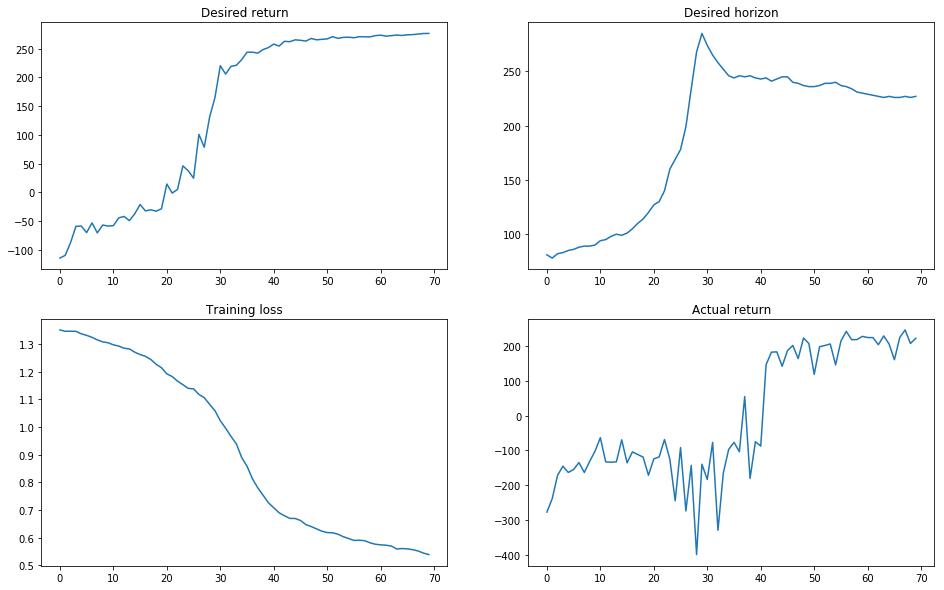

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].plot(desired_return)
axs[0, 0].set_title('Desired return')
axs[0, 1].plot(desired_horizon)
axs[0, 1].set_title('Desired horizon')
axs[1, 0].plot(training_loss)
axs[1, 0].set_title('Training loss')
axs[1, 1].plot(actual_return)
axs[1, 1].set_title('Actual return')

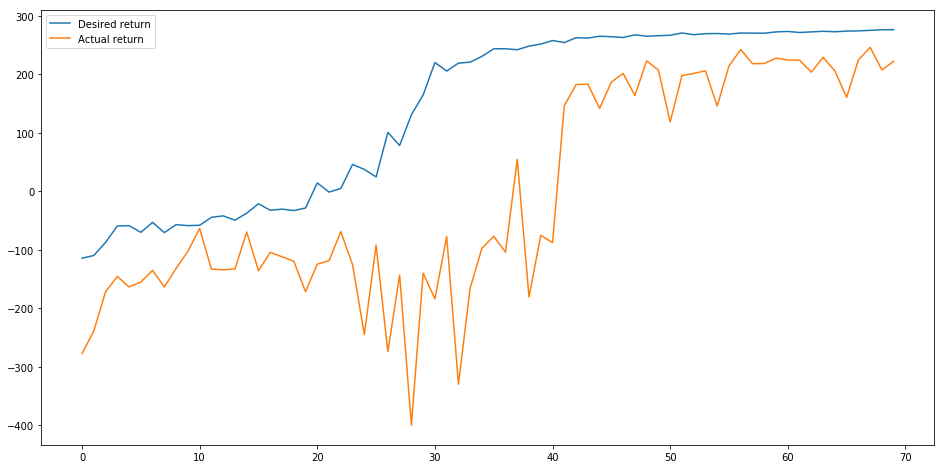

In [51]:
plt.subplots(figsize=(16, 8))
plt.plot(desired_return)
plt.plot(actual_return)
plt.legend(['Desired return', 'Actual return'])

In [62]:
from IPython.display import HTML

In [63]:

HTML("""
<p style="text-align: center">
    <video width="600" controls>
        <source src="videos/LunarLander_with_UDRL_3.mp4" type="video/mp4">
    </video>
<p>
""")

In [64]:
HTML("""
<p style="text-align: center">
    <video width="600" controls>
        <source src="videos/LunarLander_with_UDRL_4.mp4" type="video/mp4">
    </video>
<p>
""")